In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import gammaincinv, gammainc, gamma

In [3]:
from convenience_functions import *

# Problem 1: Building a galaxy scene

## [1a] Write down the 2D Sersic Model

First, let's implement a Sersic model of a galaxy. The Sersic profile is written as:

$$ I(x,y) = I_e \exp\left( -b_n\left[ \left( \frac{r(x,y)}{R_{\rm eff}}\right)^{(1/n)} - 1 \right] \right)$$

where $I_e$ is the amplitude of the profile, $n$ the Sersic index, $R_{\rm eff}$ is the effective radius, and $b_n$ is defined such that $\Gamma(2n) = 2\gamma(2n,b_n)$ where $\Gamma(w)$ is the gamma function and $\gamma(w,z)$ is the lower incomplete gamma function.

$r(x,y)$ is our distance metric, defined as:

$$ r(x,y)^2 = (x-x_0)^2 + (y-y_0)^2(1-\epsilon)^{-2}$$

for an ellipticity $\epsilon$ -- you might notice that we're not dealing with rotation here, for simplicity, but rotating the ellipse can be done by transforming $r(x,y)$ given some position angle.

In [243]:
def sersic2d ( x, y, amplitude, n, r_eff, ellip, x_0=None, y_0=None ):
    if x_0 is None:
        x_0 = x.shape[1]//2
    if y_0 is None:
        y_0 = y.shape[0]//2

    x = x - x_0
    y = y - y_0
    
    bn = gammaincinv(2.*n, 0.5)
    yb = (1 - ellip) * r_eff
    
    rnormed = np.sqrt(  (x/r_eff)**2. + (y/yb)**2. )
    
    value = amplitude * np.exp( -bn * (rnormed**(1./n) - 1.) )
    print(np.mean(-bn*(rnormed**(1./n) - 1.)))
    return value

Another useful metric for this problem set will be the total flux of the Sersic model. Feel free to integrate the profile directly, or use this [analytic solution](https://ned.ipac.caltech.edu/level5/March05/Graham/Graham2.html):

$$ L_{\rm tot} = I_e R_{\rm eff}^2 2 \pi n \frac{e^{b_n}}{b_n^{2n}} \Gamma(2n),$$

In [237]:
def total_flux ( amplitude, n, r_eff, ellip, **kwargs ):
    bn = gammaincinv(2.*n, 0.5)
    term = np.exp(bn)/(bn**(2.*n))
    totflux = amplitude * r_eff**2 * 2. * np.pi * n * term * ( 1. - ellip ) * gamma(2.*n)
    return totflux


## [1b] Instantiate our Sersic model
Now that we have an implementation of the 2D Sersic, let's see how it looks for some simulated data.

In [238]:
y,x = np.mgrid[:512,:512]

In [244]:
params_0 = {'amplitude': 10., 'n':1., 'r_eff':30., 'ellip':0.7, 'x_0':350, 'y_0':350}
params_1 = {'amplitude': 1., 'n':2., 'r_eff':30., 'ellip':0.2, 'x_0':200, 'y_0':150}

galaxy_0 = sersic2d(x, y, **params_0)
#galaxy_1 = sersic2d(x,y,**params_1)

noise = np.random.normal(0., 1., x.shape)

-27.894477165022842


In [229]:
galaxy_0.max()

53.566939800333245

(<matplotlib.image.AxesImage at 0x128313e50>, <Axes: >)

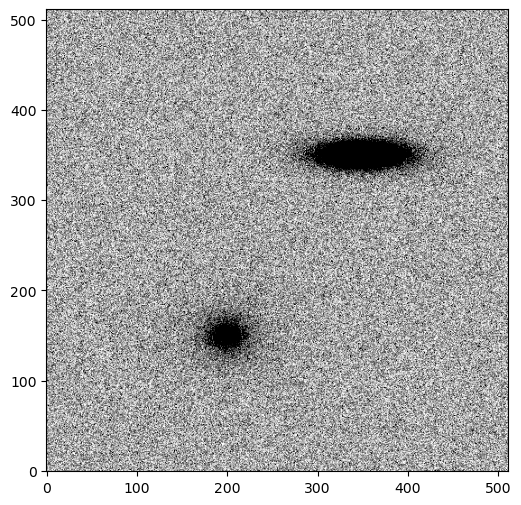

In [8]:
fig, axarr = plt.subplots(1,1,figsize=(6,6))
our_imshow(galaxy_0 + galaxy_1 + noise)

## [1c] Check your work

Astropy also has an implementation of the Sersic2D model -- let's now check our work against the distributed model.

In [9]:
from astropy.modeling.functional_models import Sersic2D

apgalaxy_0 = Sersic2D(**params_0)
apgalaxy_1 = Sersic2D(**params_1)

In [10]:
np.isclose(apgalaxy_1(x,y), galaxy_1).all()

True

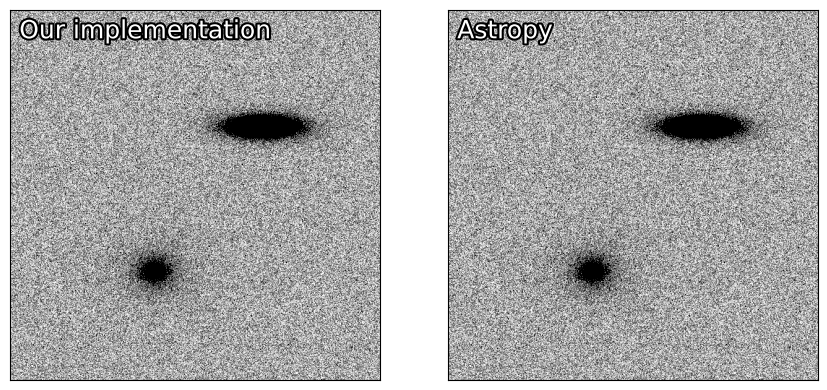

In [11]:
fig, axarr = plt.subplots(1,2,figsize=(9,4))
our_imshow(galaxy_0 + galaxy_1 + noise, ax=axarr[0])
our_imshow(apgalaxy_0(x,y) + apgalaxy_1(x,y) + noise, ax=axarr[1])

for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])

our_text(
    0.025,
    0.975,
    'Our implementation',
    fontsize=18,
    color='w',
    bordercolor='k',
    borderwidth=3,
    ax=axarr[0]
)

our_text(
    0.025,
    0.975,
    'Astropy',
    fontsize=18,
    color='w',
    bordercolor='k',
    borderwidth=3,
    ax=axarr[1]
)
plt.tight_layout ()

And another way we can check our work is to see if our total flux is what we expect for each galaxy:

In [12]:
print(galaxy_0.sum()/total_flux(**params_0))
print(galaxy_1.sum()/total_flux(**params_1))

0.9999223841571975
0.9943650888486997


In [245]:
print(apgalaxy_0(x,y).sum()/total_flux(**params_0))
print(galaxy_1.sum()/total_flux(**params_1))

0.9999223841571975
0.9943650888486997


Let's also compute the magnitude of these galaxies, assuming that the pixel values are in nanojanskies:

In [13]:
def flux2mag ( flux ):
    return -2.5*np.log10(flux * 1e-9/3631. )
rmag_0 = flux2mag(total_flux(**params_0))
rmag_1 = flux2mag(total_flux(**params_1))
print(rmag_0, rmag_1)

20.128373219940503 21.225540867619724


# Problem 2: Aperture photometry

## [2a] Construct an elliptical aperture

In [14]:
def build_elliptical_aperture ( rmax, x, y, r_eff, ellip, x_0, y_0 ):
    x = x - x_0
    y = y - y_0
    semiminor = (1 - ellip) * r_eff
    ellipse = np.sqrt((x/r_eff)**2 + (y/semiminor)**2)
    regionauto = ellipse < rmax/r_eff 
    return regionauto

## [2b] Perform elliptical aperture photometry within 1$R_{\rm eff}$

By definition, an elliptical aperture at $R_{\rm eff}$ should capture half the total flux -- let's check that for this case.

(<matplotlib.contour.QuadContourSet at 0x14d092260>, <Axes: >)

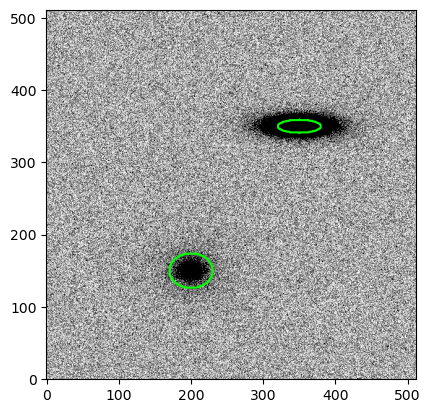

In [15]:
our_imshow(galaxy_0 + galaxy_1 + noise)

our_contour(build_elliptical_aperture(params_1['r_eff'], x,y, params_1['r_eff'], params_1['ellip'], params_1['x_0'], params_1['y_0'],),
           colors='lime')
our_contour(build_elliptical_aperture(params_0['r_eff'], x,y, params_0['r_eff'], params_0['ellip'], params_0['x_0'], params_0['y_0'],),
           colors='lime')

In [16]:
mask_0 = build_elliptical_aperture(params_0['r_eff'], x,y, params_0['r_eff'], params_0['ellip'], params_0['x_0'], params_0['y_0'],)
mask_1 = build_elliptical_aperture(params_1['r_eff'], x,y, params_1['r_eff'], params_1['ellip'], params_1['x_0'], params_1['y_0'],)

In [17]:
print(galaxy_0[mask_0].sum() / galaxy_0.sum(), galaxy_1[mask_1].sum() / galaxy_1.sum())

0.4953354388693402 0.5027583632856428


## [2c] Perform aperture photometry at $2R_{\rm eff}$

Because $R_{\rm eff}$ is the aperture that contains half the luminosity, a naive guess for a good aperture might be twice that -- let's see how this performs.

(<matplotlib.contour.QuadContourSet at 0x14d2849a0>, <Axes: >)

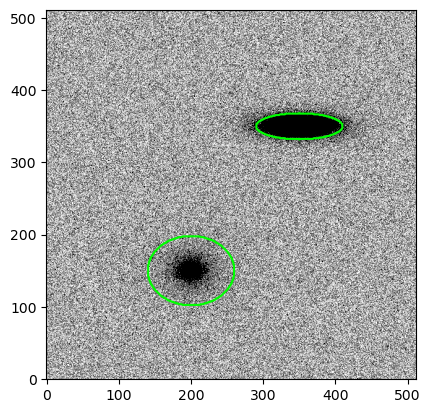

In [18]:
our_imshow(galaxy_0 + galaxy_1 + noise)

our_contour(build_elliptical_aperture(2.*params_0['r_eff'], x,y, params_0['r_eff'], params_0['ellip'], params_0['x_0'], params_0['y_0'],),
           colors='lime')
our_contour(build_elliptical_aperture(2.*params_1['r_eff'], x,y, params_1['r_eff'], params_1['ellip'], params_1['x_0'], params_1['y_0'],),
           colors='lime')

In [19]:
mask_0 = build_elliptical_aperture(2.*params_0['r_eff'], x,y, params_0['r_eff'], params_0['ellip'], params_0['x_0'], params_0['y_0'],)
mask_1 = build_elliptical_aperture(2.*params_1['r_eff'], x,y, params_1['r_eff'], params_1['ellip'], params_1['x_0'], params_1['y_0'],)

In [20]:
print(galaxy_0[mask_0].sum() / galaxy_0.sum(), galaxy_1[mask_1].sum() / galaxy_1.sum())

0.8470303040353749 0.765961120394715


# Problem 3: Model photometry

## [3a] Fitting a single Sersic

First, let's write a function to fit a single Sersic to the data.

In [21]:
from astropy.modeling.fitting import LevMarLSQFitter

In [22]:
def fit_sersic_2d(
        image, 
        init_n=1., 
        init_r_eff=None, 
        init_ellip=0.5, 
        init_theta=0., 
        init_x_0=None, 
        init_y_0=None, 
        fixed_parameters=None, 
        nan_replace=0.
    ):
    image = np.where(np.isnan(image), nan_replace, image)
    y, x = np.mgrid[:image.shape[0], :image.shape[1]]
    
    if init_x_0 is None:
        init_x_0 = int(image.shape[1] / 2)
    if init_y_0 is None:
        init_y_0 = int(image.shape[0] / 2)
    init_amplitude = image[int(init_y_0),int(init_x_0)]
    
    if init_r_eff is None:        
        #r = np.sqrt ( (x-init_x_0)**2 + (y-init_y_0)**2 )
        init_r_eff = min(image.shape) / 10       

    sersic_init = Sersic2D(
        amplitude=init_amplitude, 
        x_0=init_x_0, 
        y_0=init_y_0, 
        r_eff=init_r_eff, 
        n=init_n, 
        ellip=init_ellip, 
        theta=init_theta
    )
    if fixed_parameters is not None:
        for param in fixed_parameters:
            setattr(getattr(sersic_init, param), 'fixed', True)
                    
                
    sersic_init.bounds.update ({
        'amplitude': (init_amplitude*0.1, np.inf),
        'x_0': (0, image.shape[1]),
        'y_0': (0, image.shape[0]),
        'r_eff': (0, max(image.shape) / 2),
        'n': (0.1, 10)  # Sersic index typically ranges from 0.1 to 10
    })
    fitter = LevMarLSQFitter()

    fitted_model = fitter(sersic_init, x, y, image)
    im = fitted_model(x,y)
    return fitted_model, im

In [23]:
mock_image = galaxy_0 + noise

In [24]:
bestfit_model, bestfit_image = fit_sersic_2d(mock_image, init_x_0=params_0['x_0'], init_y_0=params_0['y_0'], init_r_eff=40.)

(<matplotlib.image.AxesImage at 0x14e194460>, <Axes: >)

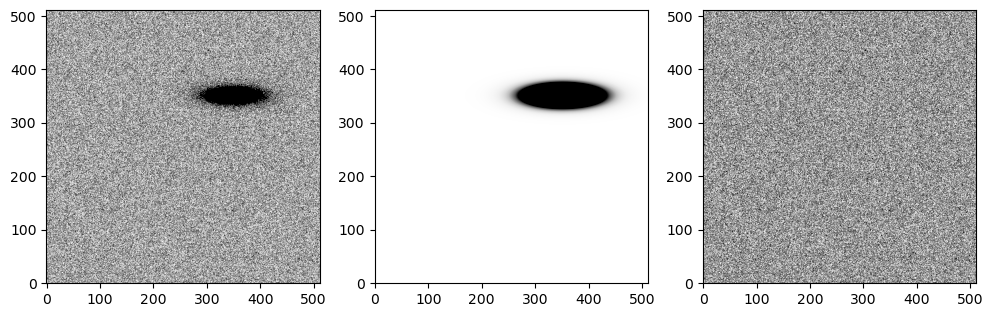

In [25]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(mock_image, ax=axarr[0])
our_imshow(bestfit_image, ax=axarr[1])
residual = mock_image - bestfit_image
our_imshow(residual,ax=axarr[2],)

With reasonable guesses for the position and effective radius of the source, this does quite well -- as expected. But what if there's another galaxy nearby?

In [26]:
params_2 = {'amplitude': 10., 'n':1., 'r_eff':60., 'ellip':0.2, 'x_0':300, 'y_0':300}
galaxy_2 = sersic2d(x,y,**params_2)

mock_image = galaxy_0 + galaxy_2 + noise

In [27]:
bestfit_model, bestfit_image = fit_sersic_2d(mock_image, init_x_0=params_0['x_0'], init_y_0=params_0['y_0'], 
                                             init_r_eff=40.,
                                            fixed_parameters=('x_0','y_0'))


(<matplotlib.image.AxesImage at 0x14e2e97e0>, <Axes: >)

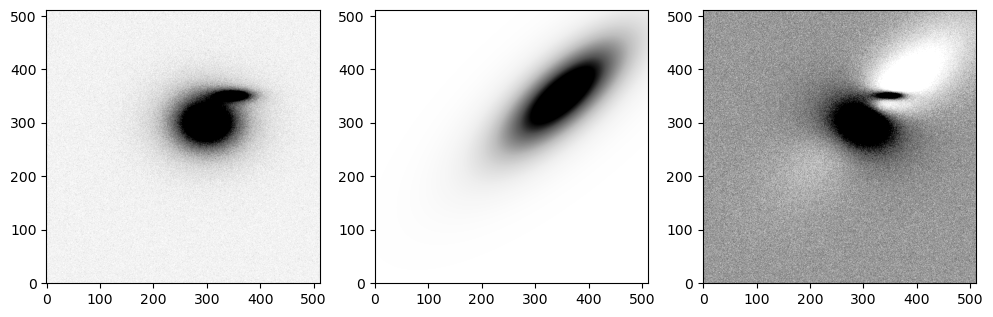

In [28]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(mock_image, ax=axarr[0])
our_imshow(bestfit_image, ax=axarr[1])
residual = mock_image - bestfit_image
our_imshow(residual,ax=axarr[2],)

Not so great. But what if our model knows that multiple galaxies exist?

## [3b] Fitting multiple models to a single scene

In [29]:
def fit_multi_sersic_2d(image, init_x_0, init_y_0, dx=0., dy=0., 
                        init_n=None, init_r_eff=None, init_ellip=None, 
                        init_theta=None, init_amplitude=None,
                        fixed_parameters=None, nan_replace=0.):
    """
    Fit multiple Sersic 2D profiles to an image with constrained position variations.
    
    Parameters:
    -----------
    image : array_like
        2D image to fit
    init_x_0 : list or array
        Initial x positions for each Sersic component
    init_y_0 : list or array  
        Initial y positions for each Sersic component
    dx : float, optional
        Maximum allowed variation in x direction from initial positions (default: 0)
    dy : float, optional
        Maximum allowed variation in y direction from initial positions (default: 0)
    init_n : list, array, or float, optional
        Initial Sersic indices. If scalar, same value used for all components (default: 1.0)
    init_r_eff : list, array, or float, optional
        Initial effective radii. If None, estimated from image size (default: None)
    init_ellip : list, array, or float, optional
        Initial ellipticities. If scalar, same value used for all components (default: 0.5)
    init_theta : list, array, or float, optional
        Initial position angles. If scalar, same value used for all components (default: 0.0)
    init_amplitude : list, array, or float, optional
        Initial amplitudes. If None, estimated from image values at positions (default: None)
    fixed_parameters : dict, optional
        Dictionary with component index as key and list of parameter names to fix as values
        e.g., {0: ['n', 'theta'], 1: ['ellip']}
    nan_replace : float, optional
        Value to replace NaNs with (default: 0.0)
        
    Returns:
    --------
    fitted_model : astropy compound model
        The fitted multi-component Sersic model
    model_image : array_like
        2D array of the fitted model evaluated on the image grid
    """
    
    # Handle NaNs
    image = np.where(np.isnan(image), nan_replace, image)
    y, x = np.mgrid[:image.shape[0], :image.shape[1]]
    
    # Convert inputs to lists and validate
    init_x_0 = np.atleast_1d(init_x_0)
    init_y_0 = np.atleast_1d(init_y_0)
    n_components = len(init_x_0)
    
    if len(init_y_0) != n_components:
        raise ValueError("init_x_0 and init_y_0 must have the same length")
    
    # Helper function to broadcast scalar parameters to all components
    def broadcast_param(param, default_val, param_name):
        if param is None:
            return [default_val] * n_components
        param = np.atleast_1d(param)
        if len(param) == 1:
            return [param[0]] * n_components
        elif len(param) == n_components:
            return list(param)
        else:
            raise ValueError(f"{param_name} must be scalar or have length {n_components}")
    
    # Set up parameter lists
    init_n_list = broadcast_param(init_n, 1.0, 'init_n')
    init_ellip_list = broadcast_param(init_ellip, 0.5, 'init_ellip')
    init_theta_list = broadcast_param(init_theta, 0.0, 'init_theta')
    
    # Handle r_eff - estimate if not provided
    if init_r_eff is None:
        default_r_eff = min(image.shape) / 10
        init_r_eff_list = [default_r_eff] * n_components
    else:
        init_r_eff_list = broadcast_param(init_r_eff, min(image.shape) / 10, 'init_r_eff')
    
    # Handle amplitude - estimate from image if not provided
    if init_amplitude is None:
        init_amplitude_list = []
        for i in range(n_components):
            x_idx = int(np.clip(init_x_0[i], 0, image.shape[1]-1))
            y_idx = int(np.clip(init_y_0[i], 0, image.shape[0]-1))
            init_amplitude_list.append(image[y_idx, x_idx])
    else:
        init_amplitude_list = broadcast_param(init_amplitude, 1.0, 'init_amplitude')
    
    # Create individual Sersic models
    sersic_models = []
    for i in range(n_components):
        sersic = Sersic2D(
            amplitude=init_amplitude_list[i],
            x_0=init_x_0[i],
            y_0=init_y_0[i], 
            r_eff=init_r_eff_list[i],
            n=init_n_list[i],
            ellip=init_ellip_list[i],
            theta=init_theta_list[i]
        )
        
        # Set bounds for this component
        sersic.bounds.update({
            'amplitude': (init_amplitude_list[i] * 0.1, np.inf),
            'x_0': (init_x_0[i] - dx, init_x_0[i] + dx),
            'y_0': (init_y_0[i] - dy, init_y_0[i] + dy),
            'r_eff': (0, max(image.shape) / 2),
            'n': (0.1, 10),
            'ellip': (0, 0.99),
            'theta': (-np.pi, np.pi)
        })
        
        # Apply fixed parameters if specified
        if fixed_parameters is not None and i in fixed_parameters:
            for param in fixed_parameters[i]:
                setattr(getattr(sersic, param), 'fixed', True)
        
        sersic_models.append(sersic)
    
    # Create compound model
    if n_components == 1:
        compound_model = sersic_models[0]
    else:
        compound_model = sersic_models[0]
        for i in range(1, n_components):
            compound_model = compound_model + sersic_models[i]
    
    # Fit the model
    fitter = LevMarLSQFitter()
    fitted_model = fitter(compound_model, x, y, image)
    
    # Generate model image
    model_image = fitted_model(x, y)
    
    return fitted_model, model_image


Now let's try re-fitting the same scene

In [30]:
params_2 = {'amplitude': 10., 'n':1., 'r_eff':60., 'ellip':0.2, 'x_0':300, 'y_0':300}
galaxy_2 = sersic2d(x,y,**params_2)

mock_image = galaxy_0 + galaxy_2 + noise

In [57]:
bestfit_model, bestfit_image = fit_multi_sersic_2d(
    mock_image, 
    init_x_0=[params_0['x_0'],params_2['x_0']], 
    init_y_0=[params_0['y_0'], params_2['y_0']], 
    init_r_eff=[30.,60.],
    fixed_parameters=('x_0','y_0')
)


(<matplotlib.image.AxesImage at 0x14f79f6a0>, <Axes: >)

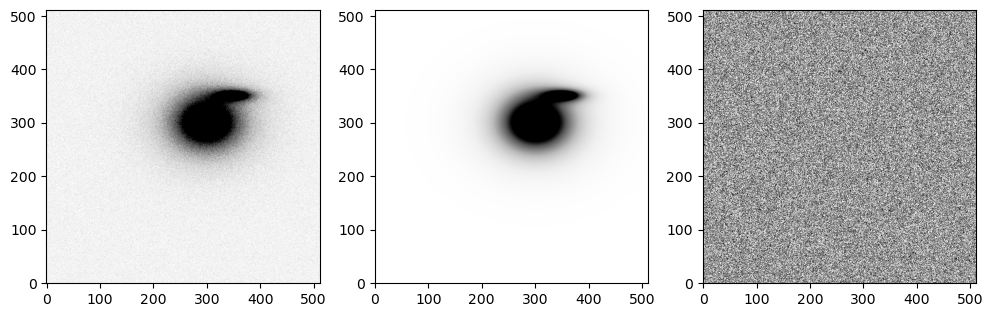

In [58]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(mock_image, ax=axarr[0])
our_imshow(bestfit_image, ax=axarr[1])
residual = mock_image - bestfit_image
our_imshow(residual,ax=axarr[2],)

## [3c] Challenge problem: probabilistically fit a scene of galaxies without prior knowledge of the number or properties of galaxies in the scene

# Problem 4: Multiband photometry

If you have all of the above notebook working, try convolving your galaxies with a Gaussian PSF to explore the effects of variations in image quality. In particular:

In [94]:
from scipy.ndimage import convolve
from scipy.fft import fft, ifft

## [4a] False color gradients

First, let's see what happens if we have two different PSFs and we just subtract out one from the other.

In [59]:
def gaussian2d(x, y, A, m, s):
    '''
    2D axisymmetric Gaussian
    
    Parameters:
    -----------
    x, y : array-like
        Coordinate arrays
    A : float or 'normalize'
        Amplitude (or 'normalize' for unit integral)
    m : array-like
        Center coordinates
    s : float
        Standard deviation (same for both x and y)
    '''
    if A == 'normalize':
        A = 1.0 / (2 * np.pi * s**2)
    
    # Radial distance from center
    r_squared = (x - m[0])**2 + (y - m[1])**2
    
    return A * np.exp(-r_squared / (2 * s**2))

In [170]:
psf_size = 65
pc = (psf_size-1)//2
psf_y,psf_x = np.mgrid[:psf_size,:psf_size]

f_std = 2.
g_std = 10.

f_psf = gaussian2d(psf_x,psf_y,'normalize',(pc,pc),f_std)
g_psf = gaussian2d(psf_x,psf_y,'normalize',(pc,pc),g_std)

In [171]:
y,x = np.mgrid[:512,:512]
sxy = sersic2d(x,y,**params_0)

In [172]:
g_img = convolve(sxy + noise,g_psf)
f_img = convolve(sxy + noise,f_psf)

In [181]:
np.nanpercentile(f_img - g_img, [0.001,0.999])

array([-3.91469726, -0.78914688])

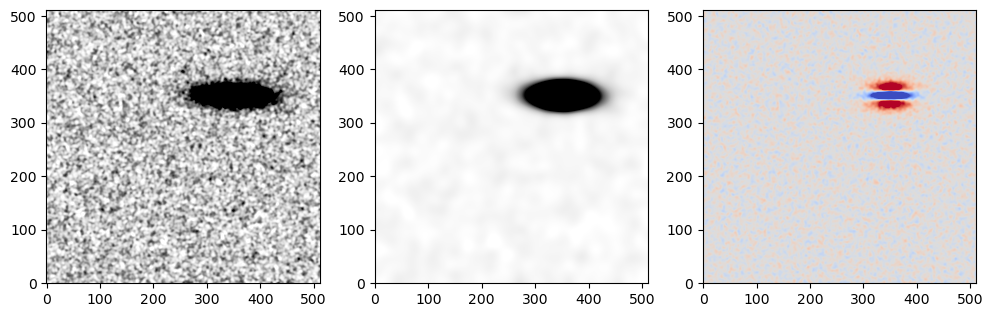

In [186]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(f_img, ax=axarr[0])
our_imshow(g_img, ax=axarr[1])
axarr[2].imshow(f_img - g_img, cmap='coolwarm_r', vmin=-2., vmax=2, origin='lower')

## [4b] A Gaussian matching kernel

Here, we're going to take advantage of the fact that the convolution of two Gaussians is a Gaussian to get an analytic solution to our matching kernel and avoid a lot of the numerical instability often found in PSF matching.

In [187]:
def gaussian_matching_kernel(sigma1, sigma2, size):
    """Create Gaussian matching kernel to convolve sigma1 PSF to sigma2 PSF"""
    if sigma2 <= sigma1:
        raise ValueError("Cannot improve seeing: sigma2 must be > sigma1")
    
    sigma_kernel = np.sqrt(sigma2**2 - sigma1**2)
    
    # Create 2D Gaussian kernel
    x, y = np.meshgrid(np.arange(size) - size//2, np.arange(size) - size//2)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma_kernel**2))
    kernel /= np.sum(kernel)  # normalize
    
    return kernel

In [188]:
matching_kernel = gaussian_matching_kernel(f_std, g_std, f_psf.shape[0])

In [189]:
f_img_convolved = convolve(f_img, matching_kernel)

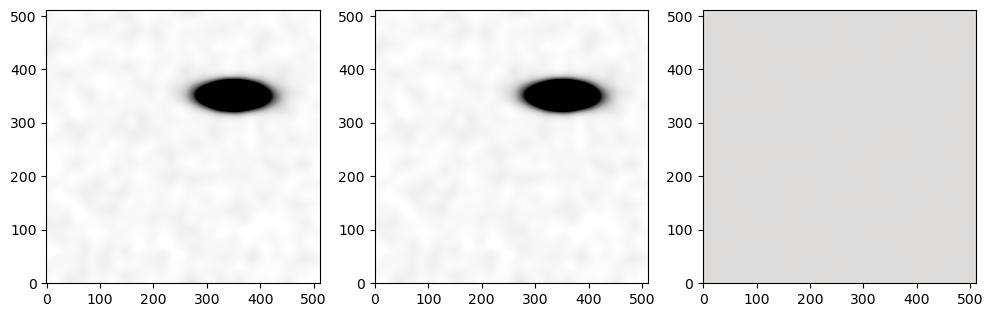

In [190]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(f_img_convolved, ax=axarr[0])
our_imshow(g_img, ax=axarr[1])
axarr[2].imshow(f_img_convolved - g_img, cmap='coolwarm_r', vmin=-2., vmax=2, origin='lower')